# ResNet의 구조

출처  
___original paper : Deep Residual Learning for Image Recognition____

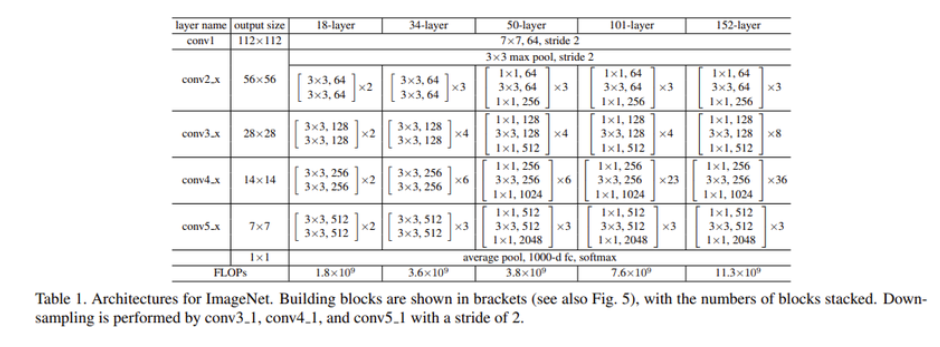

오늘의 학습 목표로 ResNet 34-layer과 50-layer을 구현할 것이다.  
첫 번째 conv1 block에서는 stride = 2 에 유의하고  
논문에서는 ImageNet Image를 224로 crop 하여 사용했음으로 output size가 112 x 112가 나왔다.  
CIFAR-10 Image를 사용하는 이 학습에서는 output이 16 x 16 으로 나올 것이다.

두 번째 block을 구현하기 위해서 함수를 정의할 예정임으로  
각 block을 자세히 보기로 했다.

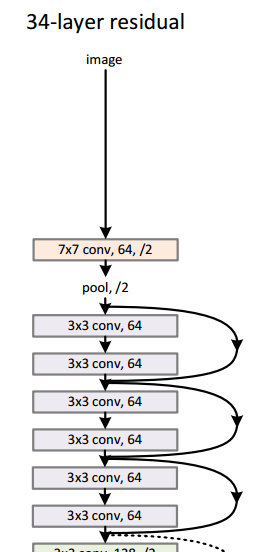

34-layer에서는 kernel size가 3으로 동일하지만  
50-layer에서는 kernel size가 1, 3으로 다름으로  
_앞으로 정의할 build_resnet_block 에서 `kernel size`를 인수로 받아야한다._  
_마찬가지로 `filtersize`도 서로 다름으로 추가로 받아야 한다._

또한, 대조군격인 Plain Model Block 설계를 위해서  
`skip connection 설정에 대한 여부`를  
받을 필요가 있다.

# 현재 이해가 가지 않는 두 가지
 - BatchNormalizaion과 같은 부과적인 layer을 어디에, 어떻게 추가할까  
 - dotted shortcut은 dimension이 증가한다고 하는데 왜 증가하는 거지?

_충격적인 사실_  
_Conv2D가 RGB 채널까지 처리하는 것을 오늘에서야 알았다._  
_RGB는 Conv3D로 처리하는 줄 알았는데 이게 아니었다._

## 이해가 가지 않는 부분, 첫 번째
___1. BatchNormalizaion과 같은 부과적인 layer을 어디에, 어떻게 추가할까___

논문의 3.4 Implementation을 참고하면  
>We adopt batch
normalization (BN) [16] right after each convolution and
before activation, following[16]

위 논문 인용에 따르면 block 안에서 `[convolution layer - BN - Activation]` 순서로 구성할 것을 제안했다.  
</br>  

하지만 또 다시 다음과 같은 의문점이 생겼다.
>The learning rate
starts from 0.1 and is divided by 10 when the error plateaus,
and the models are trained for up to 60 × 104
iterations

> We
use a weight decay of 0.0001 and a momentum of 0.9. We
do not use dropout [14], following the practice in [16].

 - Learning schedule를 작성하기 위해서 decay_step을 전달할 수 있지만 논문의 조건에 비추어 볼때, decay_step이 아닌 loss error를 통해 직접 구현해야할 듯 하다.
 - weight decay가 overfitting을 막기 위해서 라는 것은 이해했지만, 구현이 힘들 것이라 판단했다.

___따라서 전체적인 구조를 구현하는 것에 초점을 두기로 했다.___

## 이해가 가지 않는 부분, 두 번째
___2. dotted shortcut은 dimension이 증가한다고 하는데 왜 증가하는 거지?___


다음의 논문 인용에 따르면  
stride와 filtersize에 의해 dimension increase가 필요하다고 하고  
두 가지 옵션에 의해 해결할 수 있다고 한다.

>When the dimensions increase (dotted line shortcuts
in Fig. 3), we consider two options: (A) The shortcut still
performs identity mapping, with extra zero entries padded
for increasing dimensions. This option introduces no extra
parameter; (B) The projection shortcut in Eqn.(2) is used to
match dimensions (done by 1×1 convolutions). For both
options, when the shortcuts go across feature maps of two
sizes, they are performed with a stride of 2.

구현은 1x1 Conv2D strides = 2  
여기서도 BN을 실시한다.

참고로 Eqn(2)란 다음과 같다.  
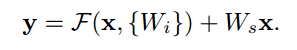

# 참고
추가로 optimizer의 momentum, learning schedule(decay)를 이해하기 위해서 다음의 영상을 참고하였다.  

_https://youtu.be/k8fTYJPd3_I_  
_https://youtu.be/QzulmoOg2JE_

전체적인 이해  
_https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8_

# 정리하자면

___Function argument___; build resnet block
```
input_size = (32, 32, 3)  
is_50 = False  
kernel_size = 3  
filtersize = 64  
is_plain = True
num_block = 3
```

___Hyper parameter___
```
learning_rate = 0.1  
alpha_lr = 0.1 # Learning rate is divided by 10 when the error plateaus  
weight_decay = 0.0001  
momentum = 0.9  
```

___Learning Schedule___
```
learning_rate
alpha_lr
momentum

```

## 주관적으로 정한 것

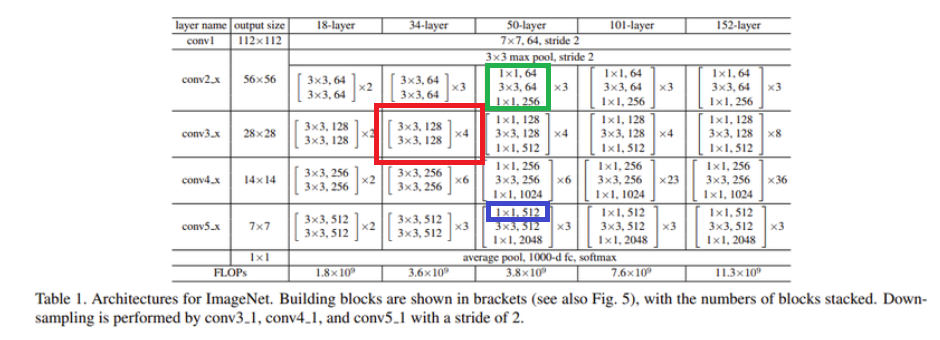

빨간색 사각형 : Stage  
초록색 사각형 : Block  
파란색 사각형 : Layers

파란색 사각형  
Conv2D - BN Layers

Stage란?  
Block * 오른쪽 수  
위 그림에서 layer name에서 convㅁ_x, ㅁ를 의미

# Layer Name

Stage[stage]_[block]_LayerName

# 진행

## Set up

In [3]:
import shutil
import glob
import os
import sys
import pickle
import random

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import tensorflow as tf

In [4]:
random_seed = 1234

random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [5]:
%matplotlib inline

# plt.style.use('default')
plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (7, 7)
# mpl.rcParams['xtick.labelbottom'] = False
# mpl.rcParams['ytick.labelleft'] = False
# mpl.rcParams['axes.grid'] = False
mpl.rcParams.update({'figure.autolayout': True})

warnings.filterwarnings('ignore')

In [6]:
# this code is for not printing warning error info
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [99]:
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.layers import Dense, Conv2D, Input, Activation, BatchNormalization, Add, MaxPooling2D, AveragePooling2D
from keras.models import Model

In [8]:
path_drive = '/content/drive/MyDrive/Colab Notebooks/GoingDeeper/2'

# Hyper Parameter

In [91]:
layer = 1

In [92]:
input_size = (32, 32, 3)
learning_rate = 0.1  
alpha_lr = 0.1 # Learning rate is divided by 10 per 10 epochs; decay step
weight_decay = 0.0001  
momentum = 0.9  
epochs = 40

In [93]:
# Simulate model building
# Build top convolution layer; conv1 7x7 stride Conv layer and Maxpooling layer
inputs = Input(shape=input_size, name='Input')
x = Conv2D(64, 7, strides=2, kernel_initializer='he_normal', activation='relu', padding='same', name='Conv2D_1')(inputs)
x = BatchNormalization(name='BN_1')(x)
x = Activation('relu', name='Acti_1')(x)
x = MaxPooling2D(3, strides=2, padding='same', name='MaxPooling2D_2')(x)

# model = Model(inputs, x)
# model.summary()

In [94]:
# 50-layer의 경우도 Conv2D - BN - Activation 순으로 설정
# 추가 자료를 통해 논문 저자가 의도한 layers가 아닐 경우에 다시 시도
# Conv2D와 BN을 묶은 Layers function
def build_resnet_layers(
    input,
    block_num,
    stage,
    filters=64,
    kernel_size=3):  

  global layer
  layer += 1

  x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal', name=f'Stage{stage}_{block_num}_Conv2D_{layer}')(input)
  x = BatchNormalization(name=f'Stage{stage}_{block_num}_BN_{layer}')(x)
  return x

In [95]:
# filters can be list in 50-layer
def build_resnet_stage(
    input_layer, 
    is_50 = False, 
    is_plain = False,
    filters = 64, 
    block_num = 3,
    stage=1,
    dotted=True):
  
  global layer
  
  # 50-layer의 경우 filters가 layer마다 값이 다름으로 리스트로 받아야만 한다.
  if is_50: assert filters is not list
  # 50-layer kernel_size list
  ls_50 = [1, 3, 1]

  x = input_layer
  
  if not is_plain:
    if not is_50:
      if not dotted:
        for num in range(1, block_num+1):
          # skip connection
          identity_input = x

          x = build_resnet_layers(x, num, stage, filters); layer+=1
          x = Activation('relu', name=f'Stage{stage}_{num}_Acti_{layer}')(x); layer+=1
          x = build_resnet_layers(x, num, stage, filters); layer+=1
          x = Add(name=f'Stage{stage}_{block_num}_Add_{layer}')([identity_input, x])
          x = Activation('relu', name=f'Stage{stage}_{num}_Acti_{layer}')(x)
      else:
        identity_input = x
        x = Conv2D(filters, 3, strides=2, padding='same', kernel_initializer='he_normal', name=f'Stage{stage}_1_Conv2D')(x)
        x = BatchNormalization(name=f'Stage{stage}_1_BN')(x); layer+=1
        x = Activation('relu', name=f'Stage{stage}_1_Acti_{layer}')(x)
        x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal', name=f'Stage{stage}_1_Conv2D_')(x)
        x = BatchNormalization(name=f'Stage{stage}_1_BN_')(x); layer+=1

        # dimension increase
        short = Conv2D(filters, 1, strides=2, padding='same', kernel_initializer='he_normal', name=f'Stage{stage}_1_Short')(identity_input)
        short = BatchNormalization(name=f'Stage{stage}_1_BN_Short')(short)

        layer+=1
        x = Add(name=f'Stage{stage}_1_Add_{layer}')([x, short])
        x = Activation('relu', name=f'Stage{stage}_1_Acti_{layer}')(x); layer+=1

        for num in range(2, block_num+1):
          # skip connection
          identity_input = x

          x = build_resnet_layers(x, num, stage, filters); layer+=1
          x = Activation('relu', name=f'Stage{stage}_{num}_Acti_{layer}')(x)
          x = build_resnet_layers(x, num, stage, filters); layer+=1
          x = Add(name=f'Stage{stage}_{block_num}_Add_{layer}')([identity_input, x]); layer+=1
          x = Activation('relu', name=f'Stage{stage}_{num}_Acti_{layer}')(x)
    else:
      pass
  else:
    pass

  return x

In [96]:
# filters; stage와 34, 50-layer를 통해 알 수 있으므로 받지 않는다.
def build_resnet(
    input_size,
    num_blocks_ls,
    num_classes,
    is_50 = False,
    is_plain = False):

  inputs = Input(shape=input_size, name='Input')
  x = Conv2D(64, 7, strides=2, kernel_initializer='he_normal', activation='relu', padding='same', name='Conv2D_1')(inputs)
  x = BatchNormalization(name='BN_1')(x)
  x = Activation('relu', name='Acti_1')(x)
  x = MaxPooling2D(3, strides=2, padding='same', name='MaxPooling2D_2')(x)

  for stage, num_blocks in enumerate(num_blocks_ls):
    stage += 1
    filters = 64*2**(stage-1)

    # stage 1에서는 dotted shortcut이 없으므로 그냥 진행하면 되지만 아닌 경우에는 size 처리가 필요하다.
    if stage == 1:
      x = build_resnet_stage(x, is_50, is_plain, filters, num_blocks, stage, dotted=False)
    else:
      x = build_resnet_stage(x, is_50, is_plain, filters, num_blocks, stage, dotted=True)
    
    x = AveragePooling2D()

  return Model(inputs, x)


In [98]:
num_blocks_ls = [3, 4, 6, 3]
model = build_resnet(input_size, num_blocks_ls, 10)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv2D_1 (Conv2D)              (None, 16, 16, 64)   9472        ['Input[0][0]']                  
                                                                                                  
 BN_1 (BatchNormalization)      (None, 16, 16, 64)   256         ['Conv2D_1[0][0]']               
                                                                                                  
 Acti_1 (Activation)            (None, 16, 16, 64)   0           ['BN_1[0][0]']                   
                                                                                           